前回は以下のことを学びました．

pandasによるcsvの読み込みと簡単な操作（列・行へのアクセス，numpy.ndarrayへの変換）<br>
sklearnの基本的な使い方<br>
提出までの流れ：<br>
1. 特徴ベクトルの作成
2. モデル・アルゴリズムの選定，学習
3. 予測
4. 提出

#今回学ぶこと
・検証データの作成(データ分割)<br>
・検証用データを用いたモデルの投稿前の評価

#(復習) データ読み込み
前回と同様に，まずはデータの読み込みを行います． データの読み込みはpandasのread_csvで行えます． ライブラリを使うためにはimportする必要があります． 詳細は前回の資料を参照してください．

In [4]:
#データとモジュールの読み込み
import numpy as np
import pandas as pd
# 機械学習のライブラリ．今回は線形回帰LinearRegressionを動かす．
# LinearRegressionはsklearnのlinear_modelモジュールの中にあるので，次のようにインポートする
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）
# Google Colabの場合
d_train = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2000_2024.csv") # 訓練データを読み込む．TFがGoogle Driveの一番上にdataディレクトリを置いた場合はこのようなパスになった
d_test = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2025H1_Dst99999.csv") # テストデータを読み込む． TFがGoogle Driveの一番上にdataディレクトリを置いた場合はこのようなパスになった

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#指定した列だけ取り出す
xlist = [ 'Year', 'Month', 'Day_of_month','Hour[h]', 'B_mag[nT]','Bx_GSE[nT]', 'By_GSM[nT]','Bz_GSM[nT]', 'T_proton[K]', 'N_proton[cm^-3]', 'V_sw[km/s]',
         'Flow_pressure[nPa]', 'E_field[mV/m]', 'Sunspot_num', 'f10.7[sfu]', 'Lyman_alpha[W/m^2]']
         #colabの場合はReturnで改行できる
ylist = ['Dst[nT]']
x_train = d_train[xlist]
y_train = d_train[ylist]
x_test = d_test[xlist]
y_test = d_test[ylist]


#過学習
LinearRegressionのドキュメントを見れば分かりますが，normalizeなどユーザが設定できる項目があります．また、例えば訓練を行う列を選別する(例えば効果があるかはわかりませんが時刻の情報をいれないなど)、標準化やMinMaxScaleを行う(これはのちのsectionで説明)などの前処理の工夫も考えられます。

しかし，一日の投稿回数が5回に制限されているため，全てのパターンを一日に投稿することはできません． 他にも多数の予測手法がありますし，今後，試行錯誤する要素はどんどん増加するため，毎回の予測結果を全て投稿して評価することは現実的ではありません． そこで，投稿せずに・投稿する前にモデルを評価することを考えます． 投稿する前にモデルの評価をして，悪そうなモデルの予測結果は投稿せず，良さそうな場合だけ投稿する，というのは妥当な戦略でしょう． また，コンペに限らず，モデルの事前の評価は機械学習手法の運用において常に非常に重要です． 機械学習を用いたサービスを考えた時に，とりあえず作ってみた予測モデルを本番環境で動かしてみるのは恐ろしいことでしょう． 本番環境で動かす前に一度評価して，良さそうであれば本番環境で動かすべきであるはずです．

さて，それではどのように投稿せずに・投稿する前にモデルを評価すれば良いのでしょうか？ コンペのスコアは予測と正解を用いて計算されます（今回は平均二乗誤差）． 残念ながら，テストデータの正解はわかっていないので，実際にコンペサイトから返ってくるスコアと同じものを事前に計算することはできません．

そこで，正解がわかっているデータ，すなわち訓練データについて予測を行って，誤差を計算して性能を見積もる，というのが考えられます． しかし，この方法には問題があります． モデルは訓練データの誤差を小さくするように学習しています． 非常に複雑なモデルを用いた時，訓練データに対する誤差をとにかく小さくしようとして（複雑なため，そのようなことが可能），その結果，訓練データに対して非常に精度の良い予測を行うが，訓練データに含まれないデータに対しては精度の低い予測を行ってしまう，ということがあります． このような現象・状態を過学習・過適合（overfitting）と言います． 過学習するモデルというのは驚くほど簡単に作れてしまうため，訓練データに対する誤差を用いてモデルを評価することは不適切です．

#検証データの作成と検証データを用いた評価
そこで，正解のわかっているデータの一部を学習には用いず検証（評価）に用いるということを行います． このようなデータを訓練データ（訓練集合）に対して検証データ（検証集合，validation data, validation set)と言います．

では実際にデータの分割をしてみましょう． まず，数値情報だけを用いたX_numについて行ってみます． とりあえずここでは，ラベル付きデータ全体のおよそ8割を訓練データ，残りを検証用とします． 特に，現在のラベル付きデータの前半8割を訓練データ，後ろの2割を検証データとします．

In [6]:
# 分割前に必ず定義
n_train = len(x_train)
n_valid = int(0.2 * n_train)  # 検証データの数．ラベル付きデータ数n_trainの2割を検証データにする
n_train = n_train - n_valid # 訓練データ数を計算し直す．検証データ以外全てなので，全体（n_train)からn_validationを引く
x_valid = x_train[n_train:] # 現在のX_train_numの後半2割 = 前半8割以降
x_train = x_train[:n_train] # 現在のX_train_numの前半8割．再代入する（変数名を使い回す）

# 目標値も同じように分割する
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

#あるいは以下のモジュールを使う
#from sklearn.model_selection import train_test_split

#x_train, x_valid, y_train, y_valid = train_test_split(
    #x_train, y_train, test_size=0.2, shuffle=False  # 時系列なら False
#)

In [7]:
print(len(x_train),len(x_valid))
print(len(y_train),len(y_valid))

175335 43833
175335 43833


訓練データと検証データが8:2で分けられていることが確認できます。<br>
検証データの統計的な情報も見てみましょう

In [18]:
y_valid.describe()

,Dst[nT]
count,43833.000000
mean,-9.425136
std,19.408359
min,-406.000000
25%,-16.000000
50%,-6.000000
75%,1.000000
max,71.000000


（復習）線形回帰の学習と予測
sklearnを用いる基本的な手順は，

モデルのインスタンスを作成<br>
作成したモデルオブジェクトをfitメソッドを用いて学習．fitメソッドには訓練データの入力と目標値（つまり，行列とベクトル）を渡す．<br>
学習したモデルを用いてpredictメソッドで予測．predictメソッドにはデータの入力（つまり行列）を渡す．<br>
でした．以下のようにして実行できます．

In [8]:
# モデルの作成と予測
lr = LinearRegression()# LinearRegressionのインスタンスの作成
lr.fit(x_train, y_train)# 上で作ったオブジェクトの学習

y_pred_valid = lr.predict(x_valid)#　検証データに対する予測

では，線形回帰の検証データに対する予測y_pred_validと訓練データの目標値y_validの間で平均二乗誤差を計算してみます． 自分で実装しても良いですが，sklearnにmean_squared_errorという名前で既に実装されています． 以下のようにimportして使います． 詳しくは[ドキュメント]( https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html )を読んでみてください．

In [17]:
from sklearn.metrics import mean_squared_error
mse_valid_lr = mean_squared_error(y_valid, y_pred_valid) # 最初の引数に目標値（正解），次に予測を入れるとスコアが返ってくる
print(f"線形回帰の平均二乗誤差：{mse_valid_lr}")

線形回帰の平均二乗誤差：1128.4542698189252


平均二乗誤差が千を超えており、RMSEにすると√1128.45 = 33.6となります。
データの標準偏差= 19.4よりも悪いので予測が全く当たっていないといえます。<br>
対象が自然現象なので限りなくスコアをゼロに近づけるのは困難ですが、まずは様々なモデルやパラメータ、データの前処理を試してデータのばらつき（19.4^2 = 376）を下回ることを目指し増ましょう.


#予測結果の視覚化
実際にどれくらいずれているか視覚的にも確認しよう. 今回はx軸(連番)を定義してプロットしました.

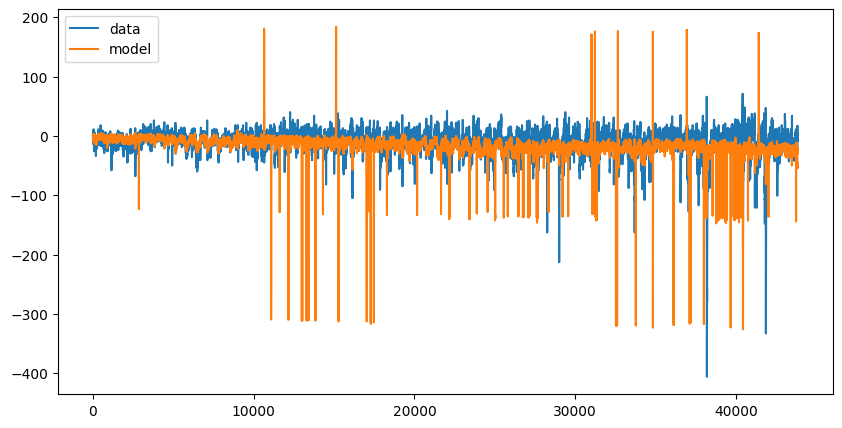

In [16]:
import matplotlib.pyplot as plt
xplot = np.arange(n_valid) # 0,1,2...n_valid-1のような配列になる
plt.figure(figsize=(10,5)) #figsize => (x,y)の図のサイズ
plt.plot(xplot,y_valid,label="data") #label; 凡例の文字
plt.plot(xplot,y_pred_valid,label="model")
plt.legend() #凡例を表示
plt.show()

In [11]:
#np.savetxt('/content/drive/My Drive/PBL2025/y_pred__lr.csv', y_pred_test,delimiter=',')
#ファイル名と保存したいnumpy配列、区切り文字の順に入力
#delimiter:区切り文字を指定します。CSVの場合は`,`を指定します。